# Games

_________________

#### Описание проекта:

По историческим данным о продажах игр, оценках пользователей и экспертов, жанрах и платформах необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Доступны данные до 2016 года.

#### Описание данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг ESRB (англ. Entertainment Software Rating Board)

#### План выполнения проекта:

* [Шаг 1.](#Шаг-1.-Просмотр-данных) Просмотр данных

* [Шаг 2.](#Шаг-2.-Подготовка-данных) Подготовка данных 

* [Шаг 3.](#Шаг-3.-Исследовательский-анализ-данных) Исследовательский анализ данных 

* [Шаг 4.](#Шаг-4.-Портрет-пользователя) Портрет пользователя

* [Шаг 5.](#Шаг-5.-Проверка-гипотез) Проверка гипотез

* [Общий вывод](#Общий-вывод)

### Шаг 1. Просмотр данных

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import os.path

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats as st

import warnings
warnings.simplefilter('ignore')

In [2]:
# импортируем датафрейм
try:
    games = pd.read_csv('/datasets/games.csv', sep=';')

In [3]:
games.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
display(games.info()), display(games.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


(None, None)

С первого взгляда видны следующие проблемы:
* Отсутсвтующие значения есть в большинстве стобцов.

* Верхний регистр в названии столбцов.

* Данные в некоторых столбцах сохранены в некорректном фармате.


### Шаг 2. Подготовка данных 

Приведём названия столбцов к нижнему регистру.

In [5]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Обработка пропусков

##### Год выпуска
Причина возникновения пропусков в столбце с годом выпуска игры - ошибка при сборе данных (MCAR). 

Для некоторых игр год указан в названии игры. Часто это спортивные симуляторы или аркады.
Попробуем восстановить некоторое количество пропусков по годам указанным в названии

In [6]:
games['year_of_release'].isnull().sum()

269

In [7]:
from dateutil.parser import parse

# функция для извлечения года выхода игры из названия
def extract_year(row):
    if row['year_of_release'] != row['year_of_release']:
        try:
            year = parse(row['name'], fuzzy=True).year
            if year > 1980 and year < 2017: # исключим игры о Второй Мировой Войне и о будущем
                return int(year)
        except:
            return row['year_of_release']
    else:
        return row['year_of_release']
    
games['year_of_release'] = games.apply(extract_year, axis=1)

Удалось восстановить 17 пропущенных значений. Не так много.

Остальные пропуски заменю нулевыми значениями. Таким образом данные не потеряются и можно будет отсеивать их на этапах анализа датасета относительно года релиза игры.

In [8]:
games['year_of_release'].fillna(0, inplace=True)

# теперь, когда пропусков в столбце нет, изменим тип данных на целочисленный
games['year_of_release'] = (games['year_of_release']
                            .astype(int, errors='ignore')
                           )

##### Жанр игры 

In [9]:
games[games['genre'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [10]:
# данные из строки №659 полностью соответствуют игре Mortal Kombat II
# которая вышла 13.09.1993 и была распродана, как в штатах количеством 1.78 млн. копий.
games.loc[659, 'name'] = 'Mortal Kombat II'
games.loc[659, 'genre'] = 'Fighting'

In [11]:
games.dropna(subset=['genre'], inplace=True)
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

##### Оценки пользователей и критиков

`TBD` - To Be Determened (англ. Рейтинг не определён). Это значит, что количество рецензий ещё не привысило порогового количества отзывов об игре. Что в случае рассмотрения датасета соответствует отсутствию рейтинга. Заменим `tbd` и пропуски значением `-1` и изменим тип данных на вещественный.

In [12]:
games['user_score'] = games['user_score'].replace(['tbd', np.nan], -1)
games['user_score'] = games['user_score'].astype(float)

# столбец с оценками критиков обработаем таким же образом
games['critic_score'] = games['critic_score'].replace(np.nan, 1)

___________________

Посчитаем суммарные продажи каждой игры и запишем их в отдельный столбец.

In [13]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

#### Вывод по предобработке данных: 

* Названия столбцов приведены к нижнему регистру.

* Небольшое количество пропусков в столбце `year_of_release` было восстановлено по названию игр. Остальная часть пропусков заменена нулевыми значениями.

* В столбце `genre` осталось 2 пропуска один из которых удалось заменить благодаря поиску в интернете по имеющимся данным. Вторая строка была удалена.

* В столбце с оценками пользователей, помимо пропусков, был абнаружен артефакт `tbd`. Заменили его и отсутсвущие значения в столбцах с оценками пользователей и критиков нулями, чтобы не терять данные.

* Так же создали столбец с общими продажами для каждой игры.
______________

### Шаг 3. Исследовательский анализ данных 

In [14]:
# сводная таблица количества выпущенных игр по годам
num_games_by_year = games.pivot_table(index='year_of_release', values='name', aggfunc='count')

# график количества игр проданных в каждый год
fig = px.histogram(games.query('year_of_release != 0'), x = 'year_of_release', marginal = 'box', opacity = 0.6)
fig.show()

У данного распределения наблюдается сильный перекос влево. Тяжёлый хвост смещает медиану и среднее к меньшему значению. Отбросим данные до 1998 года, когда количество выпускаемых игр перевалило за 300. И взглянем на характеристики распределения.

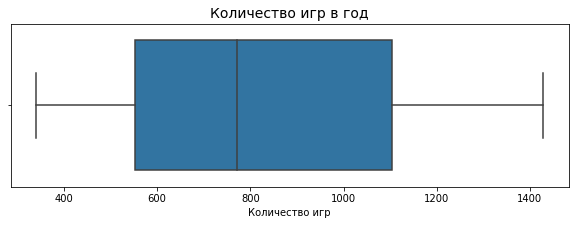

Mean: 824
Median: 772
STD: 351


In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot(y='name', data=games.query('year_of_release > 1998')
            .pivot_table(index='year_of_release',
                         values='name',
                         aggfunc='count'),
            orient='h')
plt.title('Количество игр в год', fontsize=14)
plt.xlabel('Количество игр')
plt.show()

print('Mean: {:.0f}'.format(games.query('year_of_release > 1998')
            .pivot_table(index='year_of_release',
                         values='name',
                         aggfunc='count').mean()[0]))
print('Median: {:.0f}'.format(games.query('year_of_release > 1998')
            .pivot_table(index='year_of_release',
                         values='name',
                         aggfunc='count').median()[0]))
print('STD: {:.0f}'.format(games.query('year_of_release > 1998')
            .pivot_table(index='year_of_release',
                         values='name',
                         aggfunc='count').std()[0]))

Теперь распределение ближе к нормальному. 
Для определения актуального периода и лучших консолей на рынке используем данные 1998-2016 гг.

In [16]:
games_upd = games.query('year_of_release >= 1998') 

# сводная таблица общих продаж за каждый год по каждой платформе
platform_sales = (games_upd
                  .pivot_table(index='year_of_release', columns='platform',
                               values='total_sales', aggfunc='sum').fillna(0))
print('Ежегодные продажи игр по платформам')
display(platform_sales.head())


Ежегодные продажи игр по платформам


platform,3DS,DC,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,SAT,SNES,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,,
1998,0.0,3.38,0.0,26.90,0.00,0.00,49.24,3.26,169.49,0.00,0.0,0.0,0.0,0.0,3.82,0.22,0.00,0.0,0.0,0.0,0.00,0.0
1999,0.0,5.16,0.0,38.00,0.00,0.00,57.87,4.74,145.99,0.00,0.0,0.0,0.0,0.0,0.09,0.26,0.46,0.0,0.0,0.0,0.06,0.0
2000,0.0,5.99,0.0,19.76,0.07,0.00,33.97,4.66,96.37,39.17,0.0,0.0,0.0,0.0,0.00,0.00,0.68,0.0,0.0,0.0,0.99,0.0
2001,0.0,1.07,0.0,9.24,61.53,26.34,3.25,5.47,35.59,166.43,0.0,0.0,0.0,0.0,0.00,0.00,0.28,0.0,0.0,0.0,22.26,0.0
2002,0.0,0.29,0.0,0.00,74.16,51.81,0.08,8.57,6.67,205.38,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,48.59,0.0


In [17]:
# выясним, какие платформы являются самыми успешными
top_10_platforms = (games_upd
                    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
                    .sort_values(by='total_sales', ascending=False)
                    .head(10)
                   )
print('Топ-10 игровых платформ')
display(top_10_platforms)

Топ-10 игровых платформ


,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.77
PS,456.18
PS4,314.14
GBA,312.88
PSP,289.54


Рейтинг по продажам возглавляет `PS2`, следом консоль от Microsoft `Xbox360` и японская `Nintendo Wii` замыкает тройку самых успешных платформ.


По данным о продажах игр для каждой консоли в каждый год, можно определить средний срок актуальности платформы на рынке.  

In [18]:
platform_actuality = []

for platform in platform_sales.columns:
    platform_actuality.append(platform_sales[platform].ne(0).sum())
    
platform_actuality = pd.Series(data=platform_actuality)

print('В среднем платформа сохраняет акутальность на протяжении {} лет.'.format(int(platform_actuality.mean())))

В среднем платформа сохраняет акутальность на протяжении 7 лет.


In [19]:
top_list = list(top_10_platforms.index) # список лучших платформ

# сводная таблица общих продаж за каждый год по каждой платформе
platform_sales = (games_upd
                  .query('platform in @top_list')
                  .pivot_table(index='year_of_release', columns='platform',
                               values='total_sales', aggfunc='sum').fillna(0))
display(platform_sales.head())

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1998,0.0,0.0,0.00,169.49,0.00,0.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,0.00,145.99,0.00,0.0,0.0,0.0,0.0,0.0
2000,0.0,0.0,0.07,96.37,39.17,0.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,61.53,35.59,166.43,0.0,0.0,0.0,0.0,0.0
2002,0.0,0.0,74.16,6.67,205.38,0.0,0.0,0.0,0.0,0.0


In [21]:
fig = go.Figure(data=[go.Bar(name=platform, \
                             x=platform_sales.index, \
                             y=platform_sales[platform]) for platform in top_list])  

fig.update_layout(barmode='stack', # да воздастся человеку, прописавшему этот мод
                  title='Суммарные продажи игр по платформам',
                  xaxis_title="Год",
                  yaxis_title="Количество проданных копий, млн.") 

fig.show()

На графике отчётливо видно, как одни платформы сменяют другие. 
При том, что консоль сохраняет актуальность в среднем 7 лет, и большая часть платформ теряют свои позиции на рынке с релизом PS4, **актуальным периодом** будем считать 4 года со дня старта продаж новой японской консоли - `2013-2016-гг.` 

С учётом выбранного периода, обновим список лучших консолей.

In [22]:
# отбросим данным до актуального периода
games_actual = games.query('year_of_release >= 2013')

In [23]:
top_10_platforms_actual = (games_actual
                    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
                    .sort_values(by='total_sales', ascending=False)
                    .head(10)
                   )
platform_sales_actual = (games_actual
                  .pivot_table(index='year_of_release', columns='platform',
                               values='total_sales', aggfunc='sum').fillna(0))

top_list_actual= list(top_10_platforms_actual.index)
top_10_platforms_actual

,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


Список самых успешных платформ немного изменился. В актуальный период, вместе с `PS4 `хорошие продажи показала и новая консоль от Microsoft - Xbox One. Происходит смена поколений.

Взглянем, как ситуация меняется на протяжении взятого нами периода. 

In [24]:
fig = go.Figure(data=[go.Bar(name=platform, text=round(platform_sales_actual[platform], 2), \
                             x=platform_sales_actual.index, \
                             y=platform_sales_actual[platform]) for platform in platform_sales_actual.columns])  
fig.update_traces(textposition='outside')
fig.update_layout(title='Суммарные продажи игр по платформам',
                  xaxis_title="Год",
                  yaxis_title="Количество проданных копий, млн.") 

fig.show()

* Очевидное доминирование PS4. Самая прибыльная платформа за актуальный период.

* Xbox One - вторая по потенциалу к прибыли платформа.

* Так же выделил бы персональные компьютеры. На протяжении всего перода они показывают стабильный уровень продаж (кроме 2016 года, смею полагать, что данные за этот год неполные), при том что 3DS на момент 2017-го года может потерять свою актуальность, в отличие от PC.

* Прибыль от продаж игр для Xbox360, Nintendo Wii и DS, PS3 и прочих, которые делили рынок на протяжении десятилетия, приближаются к 0.

<Figure size 1008x576 with 0 Axes>

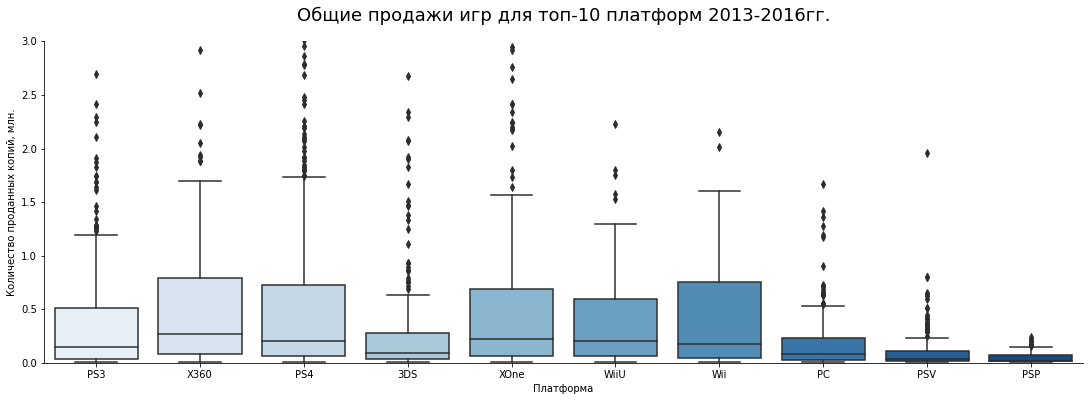

In [25]:
plt.figure(figsize=(14,8))

sns.catplot(x='platform', y='total_sales', 
            data=games_actual.query('platform in @top_list_actual'), 
            kind='box', aspect=3, palette='Blues')

plt.title('Общие продажи игр для топ-10 платформ 2013-2016гг.', fontsize=18, pad=20)
plt.xlabel('Платформа', fontsize=10)
plt.ylabel('Количество проданных копий, млн.', fontsize=10)
plt.ylim(0, 3)

plt.show()

* Все распределения имеют дополнительные значения справа, большая часть игр продаётся тиражом не больше 1 млн. копий, при этом есть большое количество гораздо более успешных релизов, которые отмеченны маркерами выбросов.

* В период с 2013 по 2016 гг. по средним продажам Xbox360 лидирует среди других платформ, опережая, в том числе и приставки от Sony.

* Из графика так же видно, что успех топовых платформ Xbox360, PS4 и Xbox One, обусловлен большим количеством "выбросов" - очень успешных игр.

* Портативные консоли PSV и PSP являются наимение комерчески успешными платформами.

Исследуем влияние на продажи игр для PS4 отзывов пользователей и критиков.


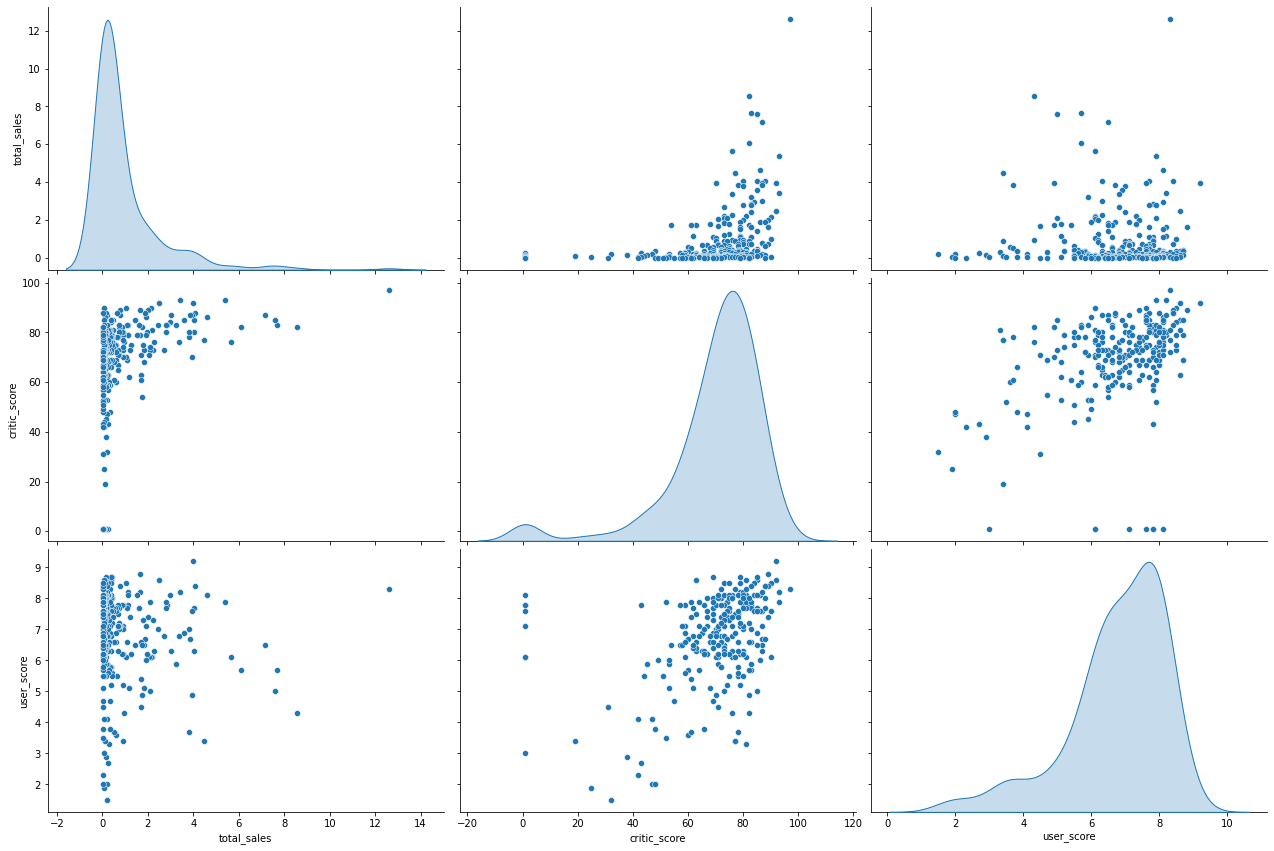

In [26]:
sns.pairplot(data=games_actual
             .query('platform == "PS4" and critic_score >= 0 and user_score >= 0')\
             [['total_sales', 'critic_score', 'user_score']], 
             height=4, aspect=1.5, diag_kind='kde')
plt.show()

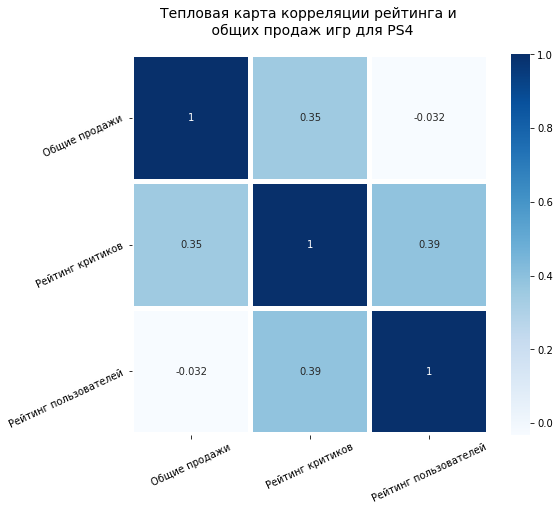

In [27]:
corr = games_actual.query('platform == "PS4" and critic_score >= 0 and user_score >= 0')\
[['total_sales', 'critic_score', 'user_score']].corr()

plt.figure(figsize=(8,7))
sns.heatmap(corr,
            cmap='Blues',
            annot=True,
            fmt='.2g',
            linewidths=4,
            linecolor='w', 
            xticklabels=['Общие продажи', 'Рейтинг критиков', 'Рейтинг пользователей'],
            yticklabels=['Общие продажи', 'Рейтинг критиков', 'Рейтинг пользователей'])
plt.xticks(rotation=25)
plt.yticks(rotation=25)
plt.title('Тепловая карта корреляции рейтинга и \n общих продаж игр для PS4', 
          fontsize = 14, pad=20)
plt.show()

Коммерческий успех игры не зависит от рейтинга пользователей напрямую, о чём свидетельствует практически нулевой коэффициент корреляции.

Коэффициент корреляции уровня продаж и рейтинга критиков положительный для PS4. На диаграмме рассеивания видно, что большое количество успешных игр имеют высокий рейтинг критиков.

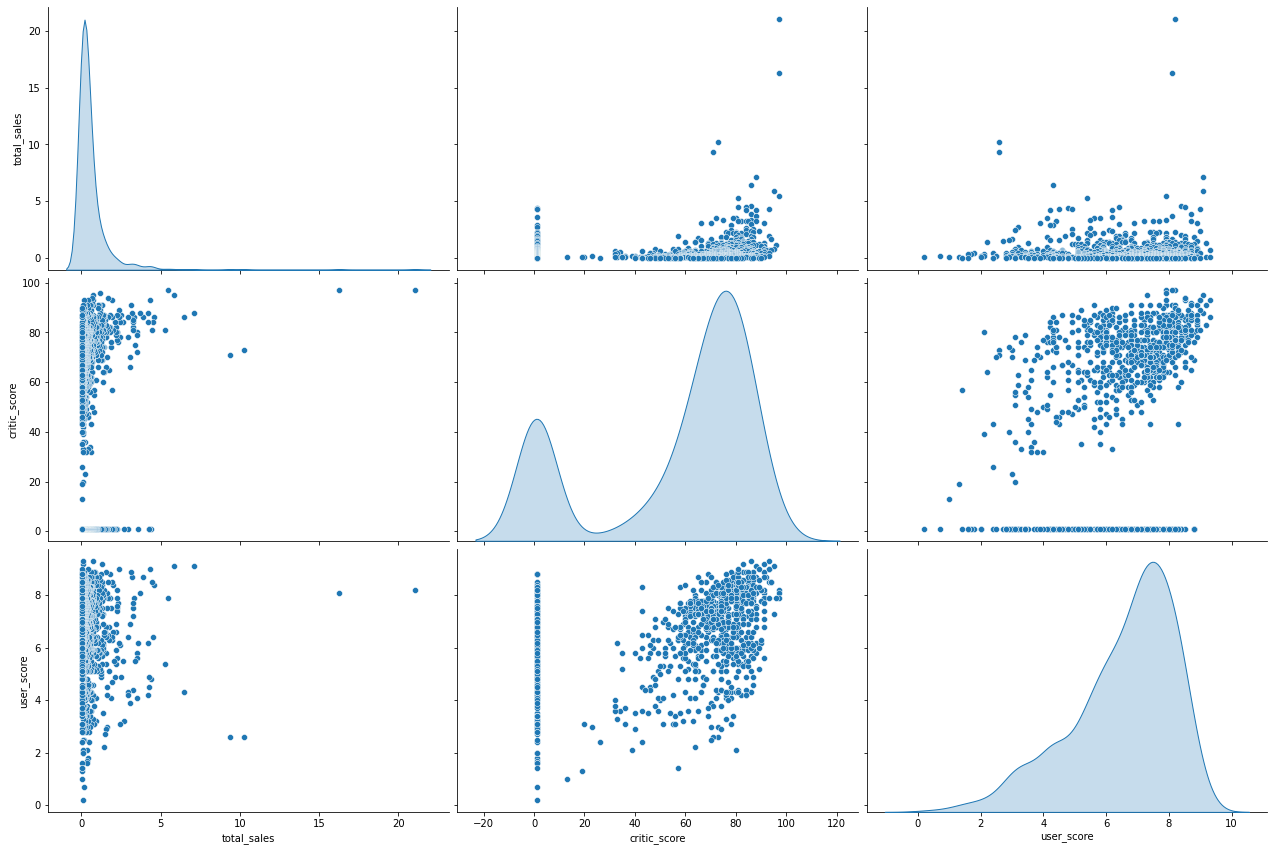

In [29]:
# диаграмма рассеивания продаж и рейтинга игр для всех платформ актуального периода
sns.pairplot(data=games_actual.query('platform != "PS4" and \
             critic_score >= 0 and user_score >= 0')\
             [['total_sales', 'critic_score', 'user_score']], 
             height=4, aspect=1.5, diag_kind='kde')
plt.show()

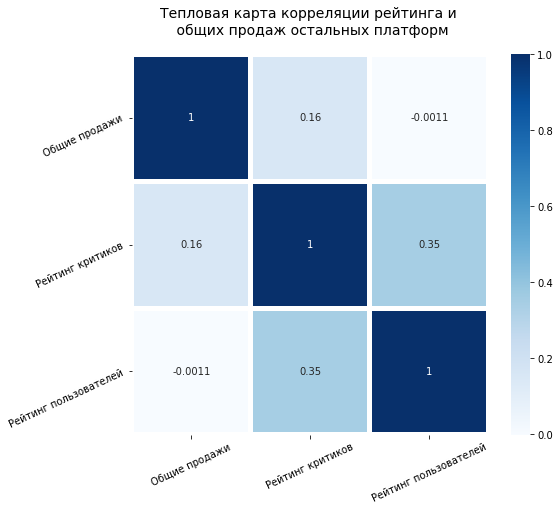

In [30]:
corr = games_actual.query('platform != "PS4" and critic_score >= 0 and user_score >= 0')\
[['total_sales', 'critic_score', 'user_score']].corr()

plt.figure(figsize=(8,7))
sns.heatmap(corr,
            cmap='Blues',
            annot=True,
            fmt='.2g',
            linewidths=4,
            linecolor='w', 
            xticklabels=['Общие продажи', 'Рейтинг критиков', 'Рейтинг пользователей'],
            yticklabels=['Общие продажи', 'Рейтинг критиков', 'Рейтинг пользователей'])
plt.xticks(rotation=25)
plt.yticks(rotation=25)
plt.title('Тепловая карта корреляции рейтинга и \n общих продаж остальных платформ', 
          fontsize = 14, pad=20)
plt.show()

Результаты по всем остальным платформам похожи на те, что мы получили для PS4, но отличаются меньшим коэффициентом корреляции рейтинга критиков и уровня продаж. 

Из чего можно сделать вывод, что рейтинг пользователей никак не влияет на коммерческие результаты игры. Рейтинг критиков в свою очередь имеет некоторое влияние.
_____________

Исследуем влияние жанра игры на её продажи в рамках самой успешной платформы - PS4.

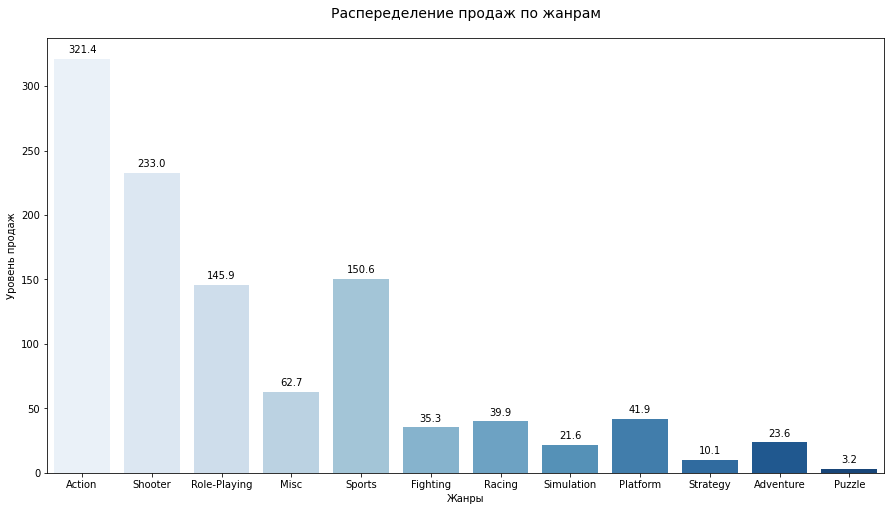

In [31]:
plt.figure(figsize=(15, 8))
genre_barplt = sns.barplot(x='genre',
                           y='total_sales',
                           data=games_actual.query('platform in @top_list_actual'),
                           palette='Blues', estimator=sum, ci=0)
for p in genre_barplt.patches:
    genre_barplt.annotate(format(p.get_height(), '.1f'), 
                       (p.get_x() + p.get_width() / 2, p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 9), 
                       textcoords='offset points') 
plt.xlabel('Жанры')
plt.ylabel('Уровень продаж')
plt.title('Распеределение продаж по жанрам', fontsize = 14, pad=20)
plt.show()

В актуальный для исследования период самым прибыльным жанром, с большим отрывом, является `Action`.  На втором месте `Shooter`. За третью позицию борятся ролевые игры и спортивные симуляторы.

Самый низкий уровень продаж демонстрируют жанры `Strategy` и `Puzzle`.

In [32]:
games_actual.pivot_table(index='genre', values='name', aggfunc='count').sort_values(by='name', ascending=False)

,name
genre,
Action,766
Role-Playing,292
Adventure,245
Sports,214
Shooter,187
Misc,155
Racing,85
Fighting,80
Platform,74


In [33]:
# интересно взглянуть, какие игры принесли жанру Action наибольший успех
games_actual.query('genre == "Action"').pivot_table(index='name', values='total_sales', aggfunc='sum')\
    .sort_values(by='total_sales', ascending=False).head(5)

,total_sales
name,
Grand Theft Auto V,56.58
Assassin's Creed IV: Black Flag,13.06
The Last of Us,10.58
LEGO Marvel Super Heroes,9.41
Watch Dogs,9.18


Здесь без сюрпризов - `GTA V`.

_______________

In [ ]:
# оценим sales_per_game
games_actual.pivot_table(index='genre', 
                         values='total_sales', 
                         aggfunc='mean').sort_values(by='total_sales', 
                                                     ascending=False)

,total_sales
genre,
Shooter,1.245882
Sports,0.703972
Platform,0.576081
Role-Playing,0.499623
Racing,0.469294
Fighting,0.441375
Action,0.420196
Misc,0.405290
Simulation,0.350968


### Шаг 4. Портрет пользователя

**Определим 5 самых популярных платформ в каждом регионе.**

In [ ]:
# функция возвращающая топ-5 платформ по продажам
def top_5_platforms(data, region_sales):
    """
    Return top 5 platforms by region
    """
    
    top_platforms = (data.pivot_table(index='platform',
                                      values=region_sales, 
                                      aggfunc='sum')
                     .sort_values(by=region_sales, ascending=False)
                     .head(5)
                    )
    return top_platforms

In [ ]:
# Суммарные продажи по регионам за актуальный период
na_sales = games_actual['na_sales'].sum()
eu_sales = games_actual['eu_sales'].sum()
jp_sales = games_actual['jp_sales'].sum()

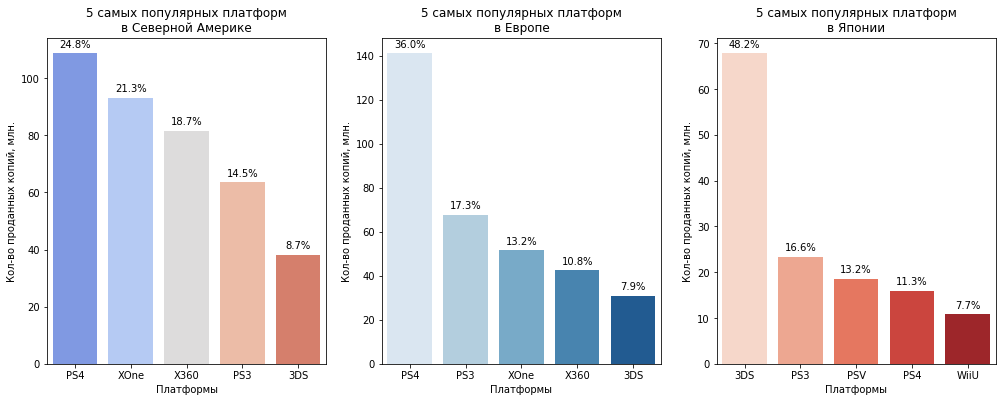

In [ ]:
# применим функцию для опередедения 5 самых популярных платформ по каждому региону
top_platforms_na, top_platforms_eu, top_platforms_jp, = [top_5_platforms(games_actual, i) \
                                                for i in ['na_sales', 'eu_sales', 'jp_sales']]


# по полученным данным построим графики
fig = plt.figure(figsize=(17, 6)) 
grid = plt.GridSpec(1, 3) # сетка графиков

ax_1 = fig.add_subplot(grid[0, 0])
ax_2 = fig.add_subplot(grid[0, 1])
ax_3 = fig.add_subplot(grid[0, 2])

# график лучших 5 платформ в Северной америке
na_plot = sns.barplot(x=top_platforms_na.index, y='na_sales', 
                      data=top_platforms_na, ax=ax_1, palette='coolwarm')
# отобразим для каждой платформы долю её продаж от общих продаж по региону
for p in na_plot.patches:
    na_plot.annotate(format(p.get_height() / na_sales, '.1%'), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')    
ax_1.set_title('5 самых популярных платформ\nв Северной Америке')
ax_1.set_xlabel('Платформы')
ax_1.set_ylabel('Кол-во проданных копий, млн.')


# график лучших 5 платформ Европы
eu_plot = sns.barplot(x=top_platforms_eu.index, y='eu_sales', 
                      data=top_platforms_eu, ax=ax_2, palette='Blues')
for p in eu_plot.patches:
    eu_plot.annotate(format(p.get_height()/eu_sales, '.1%'), 
                   (p.get_x() + p.get_width()/2, p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')   
ax_2.set_title('5 самых популярных платформ\nв Европе')
ax_2.set_xlabel('Платформы')
ax_2.set_ylabel('Кол-во проданных копий, млн.')


# график лучших 5 платформ Японии
jp_plot = sns.barplot(x=top_platforms_jp.index, y='jp_sales', 
                      data=top_platforms_jp, ax=ax_3, palette='Reds')
for p in jp_plot.patches:
    jp_plot.annotate(format(p.get_height()/jp_sales, '.1%'), 
                   (p.get_x() + p.get_width()/2, p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points')
ax_3.set_title('5 самых популярных платформ\nв Японии')
ax_3.set_xlabel('Платформы')
ax_3.set_ylabel('Кол-во проданных копий, млн.')

plt.show()

#### Вывод по платформам


**Северная Америка:** 
>* Cамой популярной платформой является `PS4`. За актуальный период продажи игр на этой платформе составили *24.8%* от всех проданных игр в этом регионе. 
>* Следом за ней идёт `Xbox One` не сильно отставая - *21.3%*. 
>* Предыдщуие поколения этих консолей имеют другое соотношение: `Xbox360` с долей рынка *18.7%* опережает `PS3` на *4.2%*. 
>* На последнем месте расположилась консоль от Nintendo - `3DS`. Доля рынка этой платформы *8.7%*.


**Европа:**
>* На рынке доминируют консоли от компании Sony. За актуальный период *36%* проданных игр приходится на `PS4`. 
>* Следом `PS3` - *17.3%*. 
>* Платформы компании Microsoft здесь не так популярны и находятся в середине списка: `Xbox One` - 3-е место, `Xbox360` - 4-е место. 
>* На 5 месте, как и в Северной Америке, `Nintendo 3DS`.


**Япония:**
>* В Японии рейтинг платформ отличается координально. Во-первых, топ-5 полностью состоит из японских консолей. На первом месте `Nintendo 3DS`, на которую приходится почти половина проданных за актуальный период игр - *48.2%*. 
>* Далее, что удевительно, предыдущее поколение консолей Sony *16.6%* - `PS3`. 
>* На третьем месте расположилась единсвтенная портативная платформа `PS Vita`. Всего лишь на 4-ом месте находится `PS4`, которая лидирует в рейтингах Северной Америки и Европы.
>* Последяя в списке платформа - Wii U от Nintendo.

_______________________


**Определим 5 самых популярных жанров в каждом регионе.**

In [ ]:
# функция возвращающая топ 5 жанров по продажам
def top_5_genres(data, region_sales):
    """
    Return top 5 genres by region
    """
    
    top_genres = (data.pivot_table(index='genre', 
                                  values=region_sales, 
                                  aggfunc='sum')
                  .sort_values(by=region_sales, ascending=False)
                 )
    return top_genres.head(5)

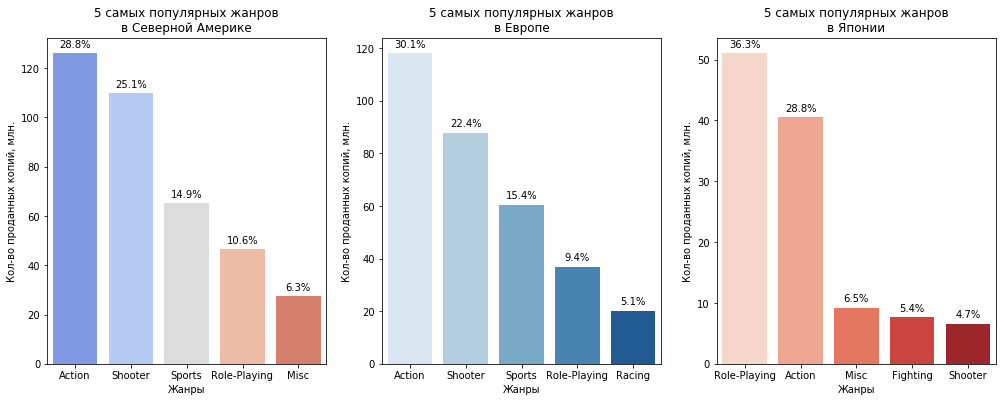

In [ ]:
# применим функцию для опередедения 5 самых популярных жанров по каждому региону
top_genres_na, top_genres_eu, top_genres_jp, = [top_5_genres(games_actual, i) \
                                                for i in ['na_sales', 'eu_sales', 'jp_sales']]

# по полученным данным построим графики
fig = plt.figure(figsize=(17, 6)) 
grid = plt.GridSpec(1, 3) # сетка графиков

ax_1 = fig.add_subplot(grid[0, 0])
ax_2 = fig.add_subplot(grid[0, 1])
ax_3 = fig.add_subplot(grid[0, 2])

# график лучших 5 жанров в Северной америке
na_plot = sns.barplot(x=top_genres_na.index, y='na_sales', 
                      data=top_genres_na, ax=ax_1, palette='coolwarm')
for p in na_plot.patches:
    na_plot.annotate(format(p.get_height()/na_sales, '.1%'), 
                   (p.get_x() + p.get_width()/2, p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords = 'offset points') 
ax_1.set_title('5 самых популярных жанров\nв Северной Америке')
ax_1.set_xlabel('Жанры')
ax_1.set_ylabel('Кол-во проданных копий, млн.')


# график лучших 5 жанров Европы
eu_plot = sns.barplot(x=top_genres_eu.index, y='eu_sales', 
                      data=top_genres_eu, ax=ax_2, palette='Blues')
for p in eu_plot.patches:
    eu_plot.annotate(format(p.get_height()/eu_sales, '.1%'), 
                   (p.get_x() + p.get_width()/2, p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points') 
ax_2.set_title('5 самых популярных жанров\nв Европе')
ax_2.set_xlabel('Жанры')
ax_2.set_ylabel('Кол-во проданных копий, млн.')


# график лучших 5 жанров Японии
jp_plot = sns.barplot(x=top_genres_jp.index, y='jp_sales', 
                      data=top_genres_jp, ax=ax_3, palette='Reds')
for p in jp_plot.patches:
    jp_plot.annotate(format(p.get_height()/jp_sales, '.1%'),
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')
ax_3.set_title('5 самых популярных жанров\nв Японии')
ax_3.set_xlabel('Жанры')
ax_3.set_ylabel('Кол-во проданных копий, млн.')

plt.show()

#### Вывод по жанрам

**Северная Америка:** 
>* `Action` - самый популярные жанр.
>* Совсем немного от него отстаёт жанр `Shooter`.
>* Спортивные симуляторы и ролевые игры (далее "RPG") посредине списка.
>* На пятом месте жанр - `Misc`. Своей позицией, обязан игре "Minecraft".


**Европа:**
>* Здесь наблюдаем точно такую же картину. Немного отличаются доли продаж и пятый по успеху жанр - `Racing`. В Европе популярны гоночные симуляторы.


**Япония:**
>* Это страна демонстрирует совершенно другое поведение пользователей. *36.3%* от общих продаж за жанром `RPG`, когда как в Европе и Америке он на четвертой позиции.
>* Жанр `Action` тоже пользуется большим успехом. Второе место.
>* На третьем месте `Misc`, бывший пятым в Северной Америке. 
>* Жанр `Fighting`, не представленный до этого, на четвертом месте. 
>* И столь популярный в Америке и Европе жанр `Shooter`, в Японии всего лишь на 5 месте.

___________________________

**Определим, как влияет возрастной рейтинг игры на её продажи в каждом представленном регионе.**


`Entertainment Software Rating Board (ESRB)` — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.


In [ ]:
# игры с каким рейтином продаются лучше всего
def region_sales_by_rating(data, region_sales):
    sales_by_rating = (data.pivot_table(index='rating', 
                                       values=region_sales, 
                                       aggfunc='sum')
                       .sort_values(by=region_sales, ascending=False)
                      )
    return sales_by_rating

rating_sales_na, rating_sales_eu, rating_sales_jp, = [region_sales_by_rating(games_actual, i) \
                                                for i in ['na_sales', 'eu_sales', 'jp_sales']]

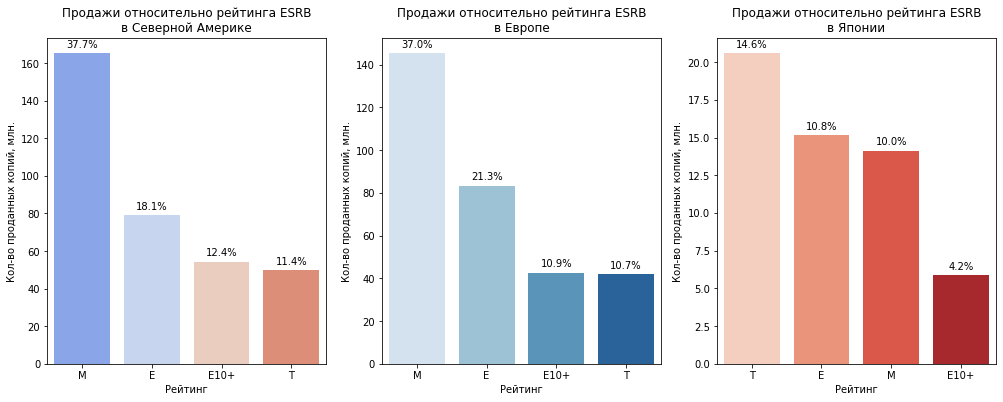

In [ ]:
# по полученным данным построим графики
fig = plt.figure(figsize=(17, 6)) 
grid = plt.GridSpec(1, 3) # сетка графиков

ax_1 = fig.add_subplot(grid[0, 0])
ax_2 = fig.add_subplot(grid[0, 1])
ax_3 = fig.add_subplot(grid[0, 2])

# график лучших 5 жанров в Северной америке
na_plot = sns.barplot(x=rating_sales_na.index, y='na_sales', 
                      data=rating_sales_na, ax=ax_1, palette='coolwarm')
for p in na_plot.patches:
    na_plot.annotate(format(p.get_height()/na_sales, '.1%'), 
                   (p.get_x() + p.get_width()/2, p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords = 'offset points') 
ax_1.set_title('Продажи относительно рейтинга ESRB\nв Северной Америке')
ax_1.set_xlabel('Рейтинг')
ax_1.set_ylabel('Кол-во проданных копий, млн.')


# график лучших 5 жанров Европы
eu_plot = sns.barplot(x=rating_sales_eu.index, y='eu_sales', 
                      data=rating_sales_eu, ax=ax_2, palette='Blues')
for p in eu_plot.patches:
    eu_plot.annotate(format(p.get_height()/eu_sales, '.1%'), 
                   (p.get_x() + p.get_width()/2, p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points') 
ax_2.set_title('Продажи относительно рейтинга ESRB\nв Европе')
ax_2.set_xlabel('Рейтинг')
ax_2.set_ylabel('Кол-во проданных копий, млн.')


# график лучших 5 жанров Японии
jp_plot = sns.barplot(x=rating_sales_jp.index, y='jp_sales', 
                      data=rating_sales_jp, ax=ax_3, palette='Reds')
for p in jp_plot.patches:
    jp_plot.annotate(format(p.get_height()/jp_sales, '.1%'),
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')
ax_3.set_title('Продажи относительно рейтинга ESRB\nв Японии')
ax_3.set_xlabel('Рейтинг')
ax_3.set_ylabel('Кол-во проданных копий, млн.')

plt.show()

`Entertainment Software Rating Board (ESRB)` — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

* В Северной Америке и Европе большинство пользователей предпочитают игры с рейтинг `М (17+)`. В Японии игры с таким рейтингом лишь на третьем месте по продажам.  

* Относительно рейтинга `T (13+)` складывается противоположная картина. В Японии игры с этим рейтингом продаются наибольшим тиражем, когда как в Северной Америке и Европе напротив, игры с данным райтингом продаются хуже всего.

* Рейтинг `E (6+)` стабильно популярен во всех регионах и распологается на второй месте по продажам во всех представленных регионах.


_________________________

<div class="alert alert-block alert-success">
<b>КОММЕНТАРИЙ РЕВЬЮВЕРА:</b> 
    
    
Евгений, безумно классный анализ портретов, и добавить нечего, читал взахлеб! Ты большой молодец! Мы действительно видим сильную схожесть Америки и Европы, совсем с небольшими отличиями: оба региона предпочитают стационарные консоли \ динамичные игры \ высокий рейтинг. Япония же сильно отличается: портативные консоли \ более спокойные игры в других жанровых предпочтениях. При этом Америке и Японии свойственна поддержка отечественных производителей.

</div>

### Шаг 5. Проверка гипотез

* **Гипотиза I**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.



Для достоверной проверки гипотез, необходимо посмотреть на распределения пользовательского рейтинга двух платформ и провести статистический тест на равенство дисперсий.

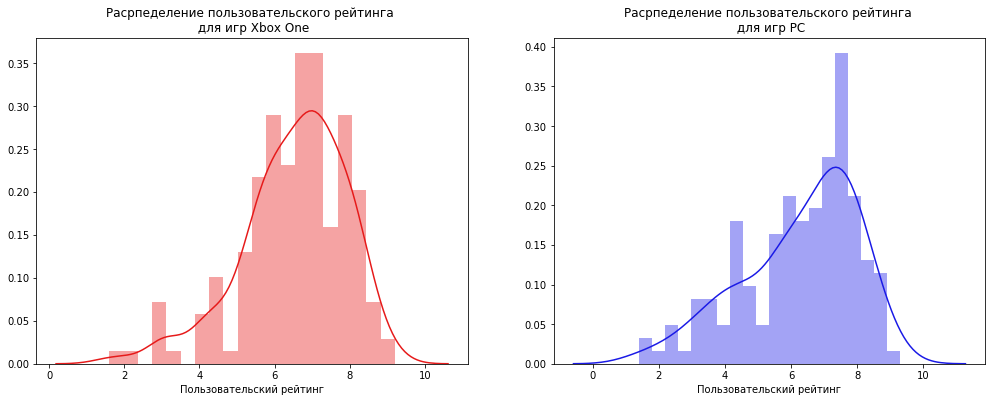

In [ ]:
fig = plt.figure(figsize=(17, 6)) 
grid = plt.GridSpec(1, 2) 

ax_1 = fig.add_subplot(grid[0, 0])
ax_2 = fig.add_subplot(grid[0, 1])

sns.distplot(a=games_actual.query('platform == "XOne" \
             and user_score > 0')['user_score'], 
             kde=True, bins=20, 
             ax=ax_1, color=(0.9, 0.1, 0.1), 
             axlabel='Пользовательский рейтинг')
ax_1.set_title('Расрпеделение пользовательского рейтинга \n для игр Xbox One')

sns.distplot(a=games_actual.query('platform == "PC" \
             and user_score > 0')['user_score'], 
             kde=True, bins=20, 
             ax=ax_2, color=(0.1, 0.1, 0.9), 
             axlabel='Пользовательский рейтинг')
ax_2.set_title('Расрпеделение пользовательского рейтинга \n для игр PC')

plt.show()

Распределения отличаются от нормального и скошены влево.

Для ненормально распределённых велечин используем тест Левена, чтобы проверить равность дисперсий двух выборок.

In [ ]:
# H0 - дисперсии выборок равны
# H1 - дисперсии отличаются 

alpha = 0.05 # уровень значимости

results = st.levene(games_actual.query('platform == "XOne" and \
                                        user_score > 0')['user_score'], 
                    games_actual.query('platform == "PC" and \
                                        user_score > 0')['user_score'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не отвергаем')

p-value: 0.003897553110130418
Отвергаем нулевую гипотезу


Дисперсии двух выборок отлчаются. 

Теперь при проведении теста Стьюдента мы явно укажем это в параметре `equal_var`.



**Нулевая и альтернативная гипотизы:**

**H0** - средние пользовательские рейтинги платформ Xbox One и PC равны.

**H1** - средние рейтинг двух этих платформ отличаются.

In [ ]:
alpha = 0.05

results = st.ttest_ind(games_actual.query('platform == "XOne" and \
                                        user_score > 0')['user_score'], 
                       games_actual.query('platform == "PC" and \
                                        user_score > 0')['user_score'], 
                       equal_var=False)

print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не отвергаем')

p-value: 0.14759594013430463
Нулевую гипотезу не отвергаем


**Вывод:**

Полученное высокое p-значение, позволяет сделать вывод, что средние двух выборок имеют статистически незначимые различия. Средние пользовательских рейтингов для платформ `Xbox One` и `PC` действительно похожи.
_____________

<div class="alert alert-block alert-success">
<b>КОММЕНТАРИЙ РЕВЬЮВЕРА:</b> 
    
* Двухсторонние гипотезы сформулированы верно
    
* Критерий проверки выбран правильно

* В ходе теста, мы получили высокое p-значение. Можно сделать вывод, что пользовательские оценки по платформам XOne PC конечно же имеют различия, но получить такие различия с вероятностью  15% можно случайно. Это слишком высокая вероятность случайности, чтобы отвергать гипотезу Но, учитывая что мы поставили порог 5%. Таким образом делаем вывод, что оценки по выбранным платформам схожи, а если различия и имеются, то они статистически незначимы.
    
* Похвально, что ты знаком с требованием нормальности и гомогенности дисперсий, однако хочу отметить, что когда наблюдений много (> 30), то распределение автоматически стремится к нормальному.
    
    
P.s. единственное, не совсем правильно употреблять слова «подтверждаем». Никакие экспериментально полученные данные никогда не подтвердят какую-либо гипотезу. Это наше фундаментальное ограничение. Данные могут лишь не противоречить ей или, наоборот, показывать крайне маловероятные результаты (при условии, что гипотеза верна). Но и в том, и в другом случае нет оснований утверждать, что выдвинутая гипотеза доказана. Допустим, данные гипотезе не противоречат, тогда мы её не отвергаем. Если же мы приходим к выводу, что получить такие данные в рамках этой гипотезы вряд ли возможно, у нас появляется основание отбросить эту гипотезу. В данном случае, данные не противоречат предположению выдвинутому в гипотезе Но, таким образом мы его просто не отвергаем.

</div>

**Гипотеза II**: Средние пользовательские рейтинги жанров Action и Sports разные.

Для начала стоит так же взглянуть на распределение двух жанров.

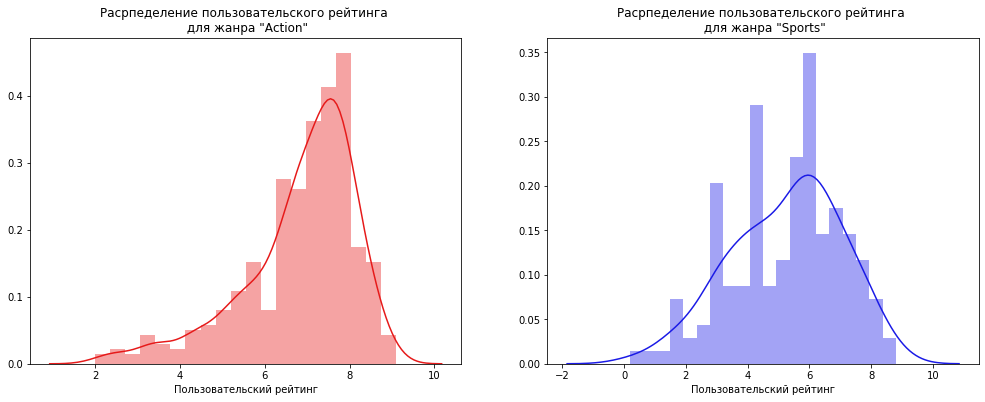

In [ ]:
fig = plt.figure(figsize=(17, 6)) 
grid = plt.GridSpec(1, 2) 

ax_1 = fig.add_subplot(grid[0, 0])
ax_2 = fig.add_subplot(grid[0, 1])

sns.distplot(a=games_actual.query('genre == "Action" \
             and user_score > 0')['user_score'], 
             kde=True, bins=20, 
             ax=ax_1, color=(0.9, 0.1, 0.1), 
             axlabel='Пользовательский рейтинг')
ax_1.set_title('Расрпеделение пользовательского рейтинга \n для жанра "Action"')

sns.distplot(a=games_actual.query('genre == "Sports" \
             and user_score > 0')['user_score'], 
             kde=True, bins=20, 
             ax=ax_2, color=(0.1, 0.1, 0.9), 
             axlabel='Пользовательский рейтинг')
ax_2.set_title('Расрпеделение пользовательского рейтинга \n для жанра "Sports"')

plt.show()

Распределения далеки от нормальных. Имеют сильный перекос влево. 
Проверим равенство дисперсий тестом Левена.

In [ ]:
# H0 - дисперсии выборок равны
# H1 - дисперсии отличаются 

alpha = 0.05 # уровень значимости

results = st.levene(games_actual.query('genre == "Action" \
                    and user_score > 0')['user_score'], 
                    games_actual.query('genre == "Sports" \
                    and user_score > 0')['user_score'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не отвергаем')

p-value: 4.2566688218274047e-07
Отвергаем нулевую гипотезу


Дисперсии двух выборок отличаются значительно. Тест Стьюдента будем проводить учитывая эту информацию.

**Нулевая и альтернативная гипотизы:**

**H0** - средние пользовательские жанров Action и Sports равны.

**H1** - средние рейтинг двух этих платформ отличаются.

In [ ]:
alpha = 0.05

results = st.ttest_ind(games_actual.query('genre == "Action" \
                       and user_score > 0')['user_score'], 
                       games_actual.query('genre == "Sports" \
                       and user_score > 0')['user_score'], 
                       equal_var=False)

print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не отвергаем')

p-value: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


**Вывод:** 

Получили очень малое значение p-value, что даёт основание отвергнуть H0 о равенстве средних пользовательских рейтингов по жанрам `Action` и `Sports`. То есть мы имеем статистически значимые различия средних двух выборок.
_____________

<div class="alert alert-block alert-success">
<b>КОММЕНТАРИЙ РЕВЬЮВЕРА:</b> 
   
* Двухсторонние гипотезы сформулированы верно
    
* Критерий проверки выбран правильно
    
* Результат корретный, но опять же, мы ничего не подтверждаем. В ходе теста мы получили очень малое p-значение, что дает нам основание отвергнуть гипотезу Но о равенстве, делаем вывод, что средние пользовательские рейтинги по жанрам Action и Sport имеют статистически значимые различия. Иногда п-значение интерпретируют как «вероятность ошибочного отклонения Но», т.е. в данном случае ОШИБОЧНО отклонить гипотезу Но можно с очень маленькой вероятностью, таким образом у нас получается достаточно оснований чтобы ее отклонить и быть спокойными)

</div>

<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ СТУДЕНТА:</b>

Я поправил выводы
    
Спасибо! Очень доходчиво разжевал мою ошибку) Кажется есть проблемы с понимаем. Пойду штудировать литературу и заполнять этот пробел
    
</div>

<div class="alert alert-block alert-success">
<b>КОММЕНТАРИЙ РЕВЬЮВЕРА 2:</b> 
    
    
Выводы стали лучше, молодец!

</div>

### Общий вывод 

* После предобработки данных и первичного анализа был выделен `актуальный период`, по которому проводилось дальнейшее исследование - `2013-2016-гг.` 
__________________
* **Анализ продаж компьютерных игр по платформам:**
    * В актуальный период, по продажам игр на платформе лидирует `PS4 `. На второй позици `PS3` Так же хорошие продажи показала консоль `Xbox One`. На четвертом и пятом месте `Nintendo 3DS` и `Xbox360` соответственно. Так же выделил бы персональные компьютеры `PC`. На протяжении всего периода они показывают стабильный уровень продаж и не имеют тенденцию к потере актуалности.

    * В период с 2013 по 2016 гг. по средним продажам `Xbox360` лидирует среди других платформ, опережая, в том числе и приставки от `Sony`. Успех топовых платформ `Xbox360`, `PS4` и `Xbox One`, обусловлен большим количеством "выбросов" - очень успешных игр. Большинство же игр на всех платформах продаётся средним тиражом до 1 млн. копий. Портативные консоли `PSV` и `PSP` являются наимение комерчески успешными платформами. Возможно, причина заключается в развивающемся рынке мобильных игр.
__________________

* **Анализ влияния оценок пользователей и критиков:**
    Исследуя влияние оценок пользователей и критиков на продажи игры, обнаружено отсутствие влияния оценок пользователей. Влияние критиков оценено, как "среднее" и имеет небольшую положительную корреляцию с уровнем продаж.
__________________

* **Анализ популярности жанров:**
    Cамым прибыльным жанром, с большим отрывом, является `Action`. На втором месте `Shooter`. За третью позицию борятся ролевые игры `RPG` и спортивные симуляторы `Sports`. Скромные коммерческие успехи преследуют жанры `Strategy` и `Puzzle`.
__________________

* **Портрет пользователя:**

    Исследуя портрет пользователя для каждого из представленных регионов, я обнаружил существенные различия в поведении пользвателей Японии и западных регионов. 
    * Самая популярная в Европе и Америке консоль `PS4` в Японии находится лишь на четвертом месте. А на первом месте располагается `Nintendo 3DS`, которая, в списках лучших платформ запада не поднималась выше пятого места.

    * Относительно самых популярных жанров картина похожа - то что популярно на западе, не обязательно будет популярно в Японии. Самые успешный жанр в Японии это `RPG` - жанр, который на западе держатся на четвертых позициях. Зеркальная ситуация складывается с жанром `Shooter` - он на пятом месте по продажам в Японии, на западе же надёжно закрепился на втором. Жанр в свою очередь `Action` любят везде - первое место на западном и второе на японском рыныках.  
    
    * В Северной Америке и Европе большинство пользователей предпочитают игры с рейтинг `М (17+)`. В Японии игры с таким рейтингом лишь на третьем месте по продажам. Относительно рейтинга `T (13+)` складывается противоположная картина. В Японии игры с этим рейтингом продаются наибольшим тиражем, когда как в Северной Америке и Европе напротив, игры с данным райтингом расходятся хуже всего. Возможно, средний возраст любителей компьютерных игр на западе выше, чем в Японии.
_________________
    
* **Проверка гипотез:**
    * `Гипотеза I` подтверждена. Средние пользовательских рейтингов для платформ `Xbox One` и `PC` действительно похожи.
    * `Гипотеза II` подтверждена. Средние пользовательских рейтингов для жанров `Action` и `Sports` отличаются друг от друга.

_______________________

* **Заключение:**

    При планировании рекламных компаний на 2017-ый год, стоит уделить отдельное внимани и применить разные стратегии к западному и восточному рынкам. На западе сделать упор на консоли `XBox One` и `PS4`, находящиеся в активной коммерческой стадии. В Японии стоит сделать основную ставку на `Nintendo 3DS`. 
    
    Такое же разделение стоит соблюсти относительно жанров игр. `RPG` и `Action` продвигать на восточном рынке. `Shooter` и `Action` на западном.
    
    Относительно рейтинга ESRB в Японии больший коммерческий успех ожидает игры для тинейджеров `T(13+)`. На западе с большим теплом встретят проекты отмеченные рейтингом `M(17+)`.